## [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) 
(J. Ho, A. Jain, P. Abbeel 2020)

![](https://raw.githubusercontent.com/dataflowr/website/master/modules/extras/diffusions/ddpm.png)


Given a schedule $\beta_1<\beta_2<\dots <\beta_T$, the **forward diffusion process** is defined by:
$q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1},\beta_t I)$ and $q(x_{1:T}|x_0) = \prod_{t=1}^T q(x_t|x_{t-1})$.

With $\alpha_t = 1-\beta_t$ and $\overline{\alpha_t} = \prod_{i=1}^t\alpha_i$, we see that, with $\epsilon\sim\mathcal{N}(0,I)$:
\begin{align*}
x_t = \sqrt{\overline{\alpha}_t}x_0 + \sqrt{1-\overline{\alpha}_t}\epsilon.
\end{align*}
The law $q(x_{t-1}|x_t,\epsilon)$ is explicit: $q(x_{t-1}|x_t,\epsilon) = \mathcal{N}(x_{t-1};\mu(x_t,\epsilon,t), \gamma_t I)$ with,
\begin{align*}
\mu(x_t,\epsilon, t) = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon\right)\text{ and, }
\gamma_t = \frac{1-\overline{\alpha}_{t-1}}{1-\overline{\alpha}_{t}}\beta_t
\end{align*}


**Training**: to approximate **the reversed diffusion** $q(x_{t-1}|x_t)$ by a neural network given by $p_{\theta}(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_{\theta}(x_t,t), \beta_t I)$ and $p(x_T) \sim \mathcal{N}(0,I)$, we maximize the usual Variational bound:
\begin{align*}
\mathbb{E}_{q(x_0)} \ln p_{\theta}(x_0) &\geq L_T +\sum_{t=2}^T L_{t-1}+L_0 \text{ with, }L_{t-1} = \mathbb{E}_q\left[ \frac{1}{2\sigma_t^2}\|\mu_\theta(x_t,t) -\mu(x_t,\epsilon,t)\|^2\right].
\end{align*}
With the change of variable:
\begin{align*}
\mu_\theta(x_t,t) = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon_\theta(x_t,t)\right),
\end{align*}
ignoring the prefactor and sampling $\tau$ instead of summing over all $t$, the loss is finally:
\begin{align*}
\ell(\theta) = \mathbb{E}_\tau\mathbb{E}_\epsilon \left[ \|\epsilon - \epsilon_\theta(\sqrt{\overline{\alpha}_\tau}x_0 + \sqrt{1-\overline{\alpha}_\tau}\epsilon, \tau)\|^2\right]
\end{align*}



**Sampling**: to simulate the reversed diffusion with the learned $\epsilon_\theta(x_t,t)$ starting from $x_T\sim \mathcal{N}(0,I)$, iterate for $t=T,\dots, 1$:
\begin{align*}
x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon_\theta(x_t,t)\right)+\sqrt{\beta_t}\epsilon,\text{ with } \epsilon\sim\mathcal{N}(0,I).
\end{align*}

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm

In [2]:
def show_images(images, title="",pixel=28):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx].reshape(pixel, pixel, 1), cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)
    # Showing the figure
    plt.show()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

In [5]:
class MyTinyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyTinyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        return out

In [6]:
class MyTinyUNet(nn.Module):
  # Here is a network with 3 down and 3 up with the tiny block
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyTinyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyTinyBlock((1, 28, 28), 1, 10),
            MyTinyBlock((10, 28, 28), 10, 10),
            MyTinyBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyTinyBlock((10, 14, 14), 10, 20),
            MyTinyBlock((20, 14, 14), 20, 20),
            MyTinyBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyTinyBlock((20, 7, 7), 20, 40),
            MyTinyBlock((40, 7, 7), 40, 40),
            MyTinyBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyTinyBlock((40, 3, 3), 40, 20),
            MyTinyBlock((20, 3, 3), 20, 20),
            MyTinyBlock((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyTinyBlock((80, 7, 7), 80, 40),
            MyTinyBlock((40, 7, 7), 40, 20),
            MyTinyBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyTinyBlock((40, 14, 14), 40, 20),
            MyTinyBlock((20, 14, 14), 20, 10),
            MyTinyBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyTinyBlock((20, 28, 28), 20, 10),
            MyTinyBlock((10, 28, 28), 10, 10),
            MyTinyBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(nn.Linear(dim_in, dim_out), nn.SiLU(), nn.Linear(dim_out, dim_out))

In [7]:
bs = 3
x = torch.randn(bs,1,28,28)
n_steps=1000
timesteps = torch.randint(0, n_steps, (bs,)).long()
unet = MyTinyUNet()

In [8]:
y = unet(x,timesteps)
y.shape

torch.Size([3, 1, 28, 28])

In [31]:
a = np.zeros(4)
a.reshape((2,2))
a

array([0., 0., 0., 0.])

In [61]:
class DDPM(nn.Module):
    def __init__(self, network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device) -> None:
        super(DDPM, self).__init__()
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.) #used in variance_posterior
        self.network = network.to(device)

    def add_noise(self, x_start, x_noise, timesteps):
        timesteps = timesteps.reshape(-1, 1, 1, 1)
        return self.alphas[timesteps]**0.5 * x_start + (1 - self.alphas[timesteps])**0.5 * x_noise

    def reverse(self, x, t):
        # The network return the estimation of the noise we added
        return self.network(x, t)

    def reconstruct_x0(self, x_t, t, noise):
        x = x_t
        for k in range(t, 0, -1):
            x = self.alphas[k]**(-0.5) * (x - (1 - self.alphas[k]) * self.reverse(x,k) / (1 - self.alphas_cumprod[k])**0.5) + self.betas[k]**0.5 * noise
        return x
    
    def mu_posterior(self, x_0, x_t, t):
        '''
        compute the posterior mean
        (used in method step)
        '''
        # your code
        pass

    def variance_posterior(self, t):
        '''
        compute the posterior variance
        (used in method step)
        '''
        # your code
        pass
    
    def step(self, model_output, timestep, sample):
        '''
        one step of sampling
        '''
        
        '''
        t = timestep
        pred_original_sample = self.reconstruct_x0(sample, t, model_output).to(device)
        pred_prev_sample = self.mu_posterior(pred_original_sample, sample, t).to(device)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(device)
            variance = ((self.variance_posterior(t) ** 0.5) * noise).to(device)

        pred_prev_sample = pred_prev_sample + variance
        '''
        
        return self.alphas[timestep]**(-0.5) * ((sample - (1 - self.alphas[timestep]) * model_output) / (1 - self.alphas_cumprod[timestep])**0.5) + self.betas[timestep]**0.5 * torch.randn(sample.shape).to(device)

In [62]:
def training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device):
    """Training loop for DDPM"""

    global_step = 0
    losses = []
    
    for epoch in range(num_epochs):
        model.train()
        progress_bar = tqdm(total=len(dataloader))
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in enumerate(dataloader):
            batch = batch[0].to(device)
            noise = torch.randn(batch.shape).to(device)
            timesteps = torch.randint(0, num_timesteps, (batch.shape[0],)).long().to(device)

            noisy = model.add_noise(batch, noise, timesteps)
            noise_pred = model.reverse(noisy, timesteps)
            loss = F.mse_loss(noise_pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "step": global_step}
            losses.append(loss.detach().item())
            progress_bar.set_postfix(**logs)
            global_step += 1
        progress_bar.close()

In [63]:
learning_rate = 1e-3
root_dir = './data/'
dataset = torchvision.datasets.MNIST(root=root_dir, train=True, transform=transforms.ToTensor(), download=True)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=4096, shuffle=True)

In [64]:
num_epochs = 10
num_timesteps = 1000
network = MyTinyUNet()
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)
optimizer = torch.optim.AdamW(network.parameters(), lr=learning_rate)
training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device)        

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [65]:
def generate_image(ddpm, sample_size, channel, height, width):
    """Generate the image from the Gaussian noise"""

    frames = []
    frames_mid = []
    with torch.no_grad():
        timesteps = list(range(ddpm.num_timesteps))[::-1]
        sample = torch.randn(sample_size, channel, height, width).to(device)
        
        for i, t in enumerate(tqdm(timesteps)):
            time_tensor = (torch.ones(sample_size, 1) * t).long().to(device)
            residual = ddpm.reverse(sample, time_tensor).to(device)
            sample = ddpm.step(residual, time_tensor[0], sample)

            if t==500:
                sample_squeezed = torch.squeeze(sample)
                for i in range(sample_size):
                    frames_mid.append(sample_squeezed[i].detach().cpu().numpy())

        sample = torch.squeeze(sample)
        for i in range(sample_size):
            frames.append(sample[i].detach().cpu().numpy())
    return frames, frames_mid

In [66]:
generated, generated_mid = generate_image(model, 100, 1, 28, 28)

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Si

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Si

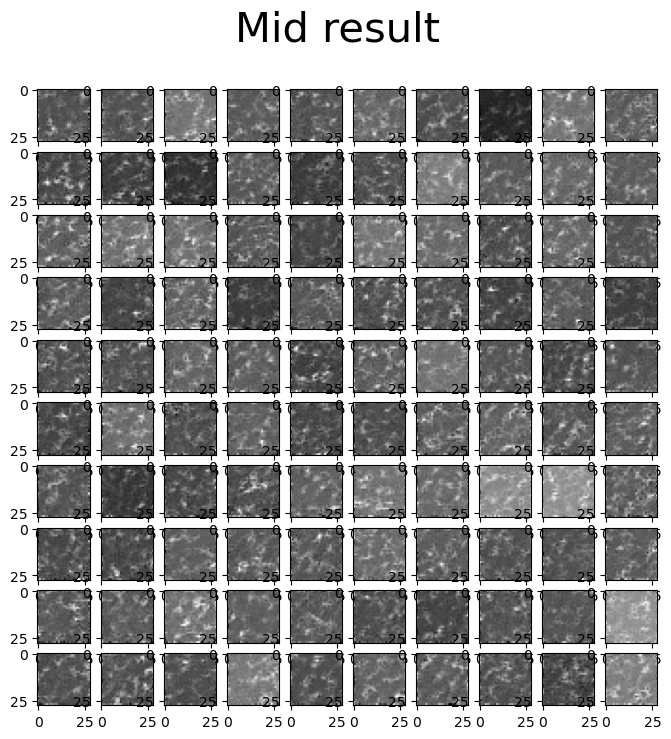

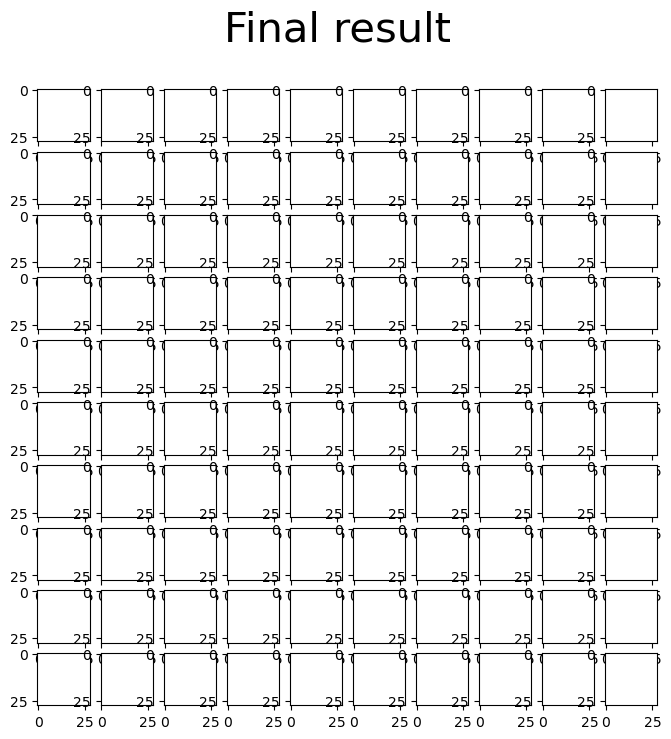

In [67]:
show_images(generated_mid, "Mid result")
show_images(generated, "Final result")